In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter


In [2]:
class Discriminator(nn.Module):
    def __init__(self, img_dim: int) -> None:
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.disc(x)

In [3]:
class Generaotr(nn.Module):
    def __init__(self, z_dim: int, img_dim: int) -> None:
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.gen(x)

In [4]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} for training...")

Using cuda for training...


In [5]:
# Hyperparameters
learning_rate = 3e-4
z_dim = 64
img_dim = 28 * 28 * 1
batch_size = 32
num_epochs = 250

In [6]:
disc = Discriminator(img_dim).to(device)
gen = Generaotr(z_dim, img_dim).to(device)
fixed_noise = torch.randn(batch_size, z_dim).to(device)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5,)),]
)
dataset = datasets.MNIST(root="dataset/", transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

opt_disc = optim.Adam(disc.parameters(), lr=learning_rate)
opt_gen = optim.Adam(gen.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")

step = 0

Epoch [0/250] Batch 0/1875 	-->	 Loss D: 0.6758, Loss G:  0.7721
Epoch [1/250] Batch 0/1875 	-->	 Loss D: 0.9947, Loss G:  0.5472
Epoch [2/250] Batch 0/1875 	-->	 Loss D: 0.6554, Loss G:  0.8725
Epoch [3/250] Batch 0/1875 	-->	 Loss D: 0.4756, Loss G:  1.1753
Epoch [4/250] Batch 0/1875 	-->	 Loss D: 0.8567, Loss G:  0.8380
Epoch [5/250] Batch 0/1875 	-->	 Loss D: 0.4216, Loss G:  1.3305
Epoch [6/250] Batch 0/1875 	-->	 Loss D: 0.5264, Loss G:  1.0167
Epoch [7/250] Batch 0/1875 	-->	 Loss D: 0.7283, Loss G:  1.0295
Epoch [8/250] Batch 0/1875 	-->	 Loss D: 0.5421, Loss G:  1.4301
Epoch [9/250] Batch 0/1875 	-->	 Loss D: 0.4075, Loss G:  1.5713
Epoch [10/250] Batch 0/1875 	-->	 Loss D: 0.4372, Loss G:  1.7143
Epoch [11/250] Batch 0/1875 	-->	 Loss D: 0.5250, Loss G:  1.5966
Epoch [12/250] Batch 0/1875 	-->	 Loss D: 0.6361, Loss G:  1.0155
Epoch [13/250] Batch 0/1875 	-->	 Loss D: 0.3857, Loss G:  1.5663
Epoch [14/250] Batch 0/1875 	-->	 Loss D: 0.5300, Loss G:  1.5608
Epoch [15/250] Batch

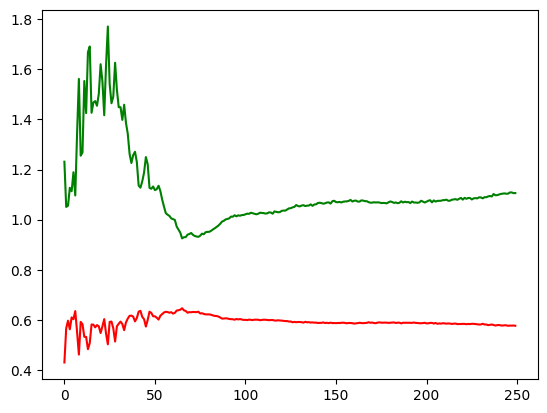

In [7]:
disc_loss = []
gen_loss = []

for epoch in range(num_epochs):
    running_disc_loss = 0.0
    running_gen_loss = 0.0
    
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        # Training the Discriminator: max log(D(real)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)

        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        running_disc_loss += lossD.item()

        # Training the Generator: min log(1 - D(G(z))) <--> max log(D(G(z)))
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))

        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        running_gen_loss += lossG.item()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \t-->\t "
                f"Loss D: {lossD:.4f}, Loss G: {lossG: 0.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)

                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image("MNIST Fake Images", img_grid_fake, global_step=step)
                writer_real.add_image("MNIST Real Images", img_grid_real, global_step=step)

                step += 1
    
    disc_loss.append(running_disc_loss / len(loader))
    gen_loss.append(running_gen_loss / len(loader))

print(f"Finished training.")

plt.plot(np.array(disc_loss), "r")
plt.plot(np.array(gen_loss), "g")
plt.show()